# **Credit Risk Analysis**
Jeremy Evan

#### **1. Importing Data & Libraries**

In [4]:
# Importing Libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score
from scipy import stats 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import warnings

import itertools

from imblearn.over_sampling import SMOTE

%matplotlib inline
warnings.filterwarnings('ignore')

# Importing Data
data = pd.read_csv('G:\My Drive\Kuliah di FTSL\Rakamin IDX Virtual Internship\loan_data_2007_2014.csv')

# Extending Output Line Amount
pd.options.display.max_rows = 10000000
np.set_printoptions(edgeitems = 25, linewidth = 10000000)

#### **2. Defining Functions**

In [5]:
# Confusion Matrix Plot
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Feature Importance Plot
def plot_feature_importances(model,X_train):
    
    xaxes = list(X_train.columns.values)
    yaxes = list(model.feature_importances_)
    
    h = dict(zip(xaxes,yaxes))
    s = [(k, h[k]) for k in sorted(h, key=h.get, reverse=False)]
    s = dict(s)
    xaxes = list(s.keys())
    yaxes = list(s.values())
    
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), yaxes, align='center') 
    plt.yticks(np.arange(n_features), xaxes) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

def rocurve(logreg, X_train, X_test, y_train, y_test):
    
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    import seaborn as sns
    %matplotlib inline
    
    y_test_score = logreg.decision_function(X_test)
    y_train_score = logreg.decision_function(X_train)

    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)
    train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_score)

    print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))
    print('train AUC: {}'.format(auc(train_fpr, train_tpr)))

    plt.figure(figsize=(10,8))
    lw = 2
    plt.plot(test_fpr, test_tpr, color='darkorange',
             lw=lw, label='Test ROC curve')
    plt.plot(train_fpr, train_tpr, color='blue',
             lw=lw, label='train ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Determine Dimensions to Preserve the Level of Variance
def find_min_pca(X_train, percentage=0.8):
    from sklearn.decomposition import PCA
    inital_components=pd.DataFrame(X_train).shape[1]
    if inital_components<10:
        print('The Data has less than 10 components, no PCA needed')
    else:
        a=int(str(inital_components)[-1])
        tens=int((inital_components-a)/10)
        for i in range(1,tens+1):
            pca = PCA(n_components=(i)*10)
            principalComponents = pca.fit_transform(X_train)
            explained_var= np.sum(pca.explained_variance_ratio_)
            if explained_var>=percentage:
                upper=i
                break
        for j in range((upper-1)*10,(upper)*10):
            pca = PCA(n_components=j)
            principalComponents = pca.fit_transform(X_train)                
            explained_var1= np.sum(pca.explained_variance_ratio_)
            if explained_var1>percentage:
                comp=j
                break
    return comp

# Determine FPR and TPR
def perf(y_test, y_pred):
    from sklearn.metrics import confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = round(fp  / (fp + tn),2)*100
    tpr = round(tp / (tp+fn),2)*100
    
    return(print(str(tpr) + '% of the positives are appropriately identified, and ' + str(fpr) + '% of the negatives are appropriately identified.'))

#### **3. Exploratory Data Analysis**

**Reading Data Columns**

In [6]:
data.columns

Index(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url',
       'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'verificatio

**Data Exploration**

In [7]:
data.loan_status.value_counts()

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [8]:
# Fully Paid (184739): Loan has been 100% paid off
# Charged Off (42475): Loan which has been stopped for further payments

# The machine will aim for the variable 'loan_status'. We classify the Fully Paid loan as 1 and the Charged Off loan as 0, and the rest will be ignored.

In [9]:
data = data[(data['loan_status'] == 'Fully Paid') | (data['loan_status'] == 'Charged Off')]
data.loan_status.value_counts()

Fully Paid     184739
Charged Off     42475
Name: loan_status, dtype: int64

In [10]:
# Converting Loan Status into Binary
data.loan_status[(data['loan_status'] == 'Fully Paid')] = 0
data.loan_status[(data['loan_status'] == 'Charged Off')] = 1

In [11]:
# Printing Loan Status as Float
data.loan_status.astype(float)

0         0.0
1         1.0
2         0.0
3         0.0
5         0.0
7         0.0
8         1.0
9         1.0
10        0.0
11        0.0
12        1.0
13        0.0
14        1.0
15        0.0
16        0.0
17        0.0
18        0.0
19        0.0
20        0.0
21        1.0
22        0.0
23        0.0
24        1.0
25        0.0
26        1.0
27        1.0
28        0.0
29        0.0
30        0.0
31        0.0
33        0.0
34        0.0
35        0.0
36        0.0
37        0.0
38        0.0
40        0.0
41        0.0
42        0.0
43        0.0
44        0.0
45        0.0
46        1.0
47        0.0
48        0.0
49        0.0
50        1.0
51        0.0
52        0.0
53        1.0
54        0.0
55        1.0
56        0.0
57        0.0
58        0.0
59        0.0
60        0.0
62        0.0
63        0.0
64        1.0
65        0.0
66        1.0
67        0.0
68        1.0
69        0.0
70        0.0
71        1.0
72        0.0
73        0.0
74        0.0
75        0.0
76    

In [12]:
# Counting the Amount of Columns
len(data.columns)

75

In [13]:
# Creating List to Store Categorical and Numerical Features
cat_feat = []
num_feat = []

##### **Column 1 - 10**

In [14]:
data.columns[1:11]

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade'],
      dtype='object')

In [15]:
for col in data.columns[1:11]:
    print(col,'\n',data[col].head(10),'\n')

id 
 0     1077501
1     1077430
2     1077175
3     1076863
5     1075269
7     1072053
8     1071795
9     1071570
10    1070078
11    1069908
Name: id, dtype: int64 

member_id 
 0     1296599
1     1314167
2     1313524
3     1277178
5     1311441
7     1288686
8     1306957
9     1306721
10    1305201
11    1305008
Name: member_id, dtype: int64 

loan_amnt 
 0      5000
1      2500
2      2400
3     10000
5      5000
7      3000
8      5600
9      5375
10     6500
11    12000
Name: loan_amnt, dtype: int64 

funded_amnt 
 0      5000
1      2500
2      2400
3     10000
5      5000
7      3000
8      5600
9      5375
10     6500
11    12000
Name: funded_amnt, dtype: int64 

funded_amnt_inv 
 0      4975.0
1      2500.0
2      2400.0
3     10000.0
5      5000.0
7      3000.0
8      5600.0
9      5350.0
10     6500.0
11    12000.0
Name: funded_amnt_inv, dtype: float64 

term 
 0      36 months
1      60 months
2      36 months
3      36 months
5      36 months
7      36 months
8      

In [16]:
# loan_amnt: numerical feature
# term: categorical feature
# int_rate: numerical feature
# installment: numerical feature

cat_feat.append('term')
num_feat.append('loan_amnt')
num_feat.append('installment')
num_feat.append('int_rate')

##### **Column 11 - 20**

In [17]:
data.columns[11:21]

Index(['emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url',
       'desc'],
      dtype='object')

In [18]:
for col in data.columns[11:21]:
    print(col,'\n',data[col].head(10),'\n')

emp_title 
 0                       NaN
1                     Ryder
2                       NaN
3       AIR RESOURCES BOARD
5      Veolia Transportaton
7           MKC Accounting 
8                       NaN
9                 Starbucks
10    Southwest Rural metro
11                     UCLA
Name: emp_title, dtype: object 

emp_length 
 0     10+ years
1      < 1 year
2     10+ years
3     10+ years
5       3 years
7       9 years
8       4 years
9      < 1 year
10      5 years
11    10+ years
Name: emp_length, dtype: object 

home_ownership 
 0     RENT
1     RENT
2     RENT
3     RENT
5     RENT
7     RENT
8      OWN
9     RENT
10     OWN
11     OWN
Name: home_ownership, dtype: object 

annual_inc 
 0     24000.0
1     30000.0
2     12252.0
3     49200.0
5     36000.0
7     48000.0
8     40000.0
9     15000.0
10    72000.0
11    75000.0
Name: annual_inc, dtype: float64 

verification_status 
 0            Verified
1     Source Verified
2        Not Verified
3     Source Verified
5    

In [19]:
# emp_length: can be numerical feature
# home_ownership: will be converted into categorical feature
# annual_inc: numerical feature
# verification_status: categorical feature

cat_feat.append('home_ownership')
cat_feat.append('verification_status')
num_feat.append('emp_length')
num_feat.append('annual_inc')

##### **Column 21 - 30**

In [20]:
data.columns[21:31]

Index(['purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record'],
      dtype='object')

In [21]:
for col in data.columns[21:31]:
    print(col,'\n', data[col].head(10),'\n')

purpose 
 0            credit_card
1                    car
2         small_business
3                  other
5                wedding
7                    car
8         small_business
9                  other
10    debt_consolidation
11    debt_consolidation
Name: purpose, dtype: object 

title 
 0                                  Computer
1                                      bike
2                      real estate business
3                                  personel
5     My wedding loan I promise to pay back
7                           Car Downpayment
8      Expand Business & Buy Debt Portfolio
9               Building my credit history.
10               High intrest Consolidation
11                            Consolidation
Name: title, dtype: object 

zip_code 
 0     860xx
1     309xx
2     606xx
3     917xx
5     852xx
7     900xx
8     958xx
9     774xx
10    853xx
11    913xx
Name: zip_code, dtype: object 

addr_state 
 0     AZ
1     GA
2     IL
3     CA
5     AZ
7     CA
8 

In [22]:
# purpose: can be categorical feature
# dti: numerical feature
# delinq_2yrs: numerical feature
# inq_last_6mths: numerical feature

cat_feat.append('purpose')
num_feat.append('dti')
num_feat.append('delinq_2yrs')
num_feat.append('inq_last_6mths')

##### **Column 31 - 40**

In [23]:
data.columns[31:41]

Index(['open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv'],
      dtype='object')

In [24]:
for col in data.columns[31:41]:
    print(col,'\n',data[col].head(10),'\n')

open_acc 
 0      3.0
1      3.0
2      2.0
3     10.0
5      9.0
7      4.0
8     11.0
9      2.0
10    14.0
11    12.0
Name: open_acc, dtype: float64 

pub_rec 
 0     0.0
1     0.0
2     0.0
3     0.0
5     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
Name: pub_rec, dtype: float64 

revol_bal 
 0     13648
1      1687
2      2956
3      5598
5      7963
7      8221
8      5210
9      9279
10     4032
11    23336
Name: revol_bal, dtype: int64 

revol_util 
 0     83.7
1      9.4
2     98.5
3     21.0
5     28.3
7     87.5
8     32.6
9     36.5
10    20.6
11    67.1
Name: revol_util, dtype: float64 

total_acc 
 0      9.0
1      4.0
2     10.0
3     37.0
5     12.0
7      4.0
8     13.0
9      3.0
10    23.0
11    34.0
Name: total_acc, dtype: float64 

initial_list_status 
 0     f
1     f
2     f
3     f
5     f
7     f
8     f
9     f
10    f
11    f
Name: initial_list_status, dtype: object 

out_prncp 
 0     0.0
1     0.0
2     0.0
3     0.0
5     0.0
7     0.0
8     0.0

In [25]:
# open_acc: numerical feature
# pub_rec: will be converted into numerical feature
# revol_bal: numerical feature
# revol_util: numerical feature
# total_acc: numerical feature

num_feat.append('pub_rec')
num_feat.append('open_acc')
num_feat.append('revol_bal')
num_feat.append('revol_util')
num_feat.append('total_acc')

##### **Column 41 - 50**

In [26]:
data.columns[41:51]

Index(['total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med'],
      dtype='object')

In [27]:
for col in data.columns[41:51]:
    print(col,'\n',data[col].head(10),'\n')

total_rec_prncp 
 0      5000.00
1       456.46
2      2400.00
3     10000.00
5      5000.00
7      3000.00
8       162.02
9       673.48
10     6500.00
11    12000.00
Name: total_rec_prncp, dtype: float64 

total_rec_int 
 0      861.07
1      435.17
2      603.65
3     2209.33
5      631.38
7      938.14
8      294.94
9      533.42
10    1177.52
11    1943.08
Name: total_rec_int, dtype: float64 

total_rec_late_fee 
 0      0.00
1      0.00
2      0.00
3     16.97
5      0.00
7      0.00
8      0.00
9      0.00
10     0.00
11     0.00
Name: total_rec_late_fee, dtype: float64 

recoveries 
 0       0.00
1     117.08
2       0.00
3       0.00
5       0.00
7       0.00
8     189.06
9     269.29
10      0.00
11      0.00
Name: recoveries, dtype: float64 

collection_recovery_fee 
 0     0.00
1     1.11
2     0.00
3     0.00
5     0.00
7     0.00
8     2.09
9     2.52
10    0.00
11    0.00
Name: collection_recovery_fee, dtype: float64 

last_pymnt_d 
 0     Jan-15
1     Apr-13
2     Jun-1

In [28]:
# No Variable is Necessary for the Model

##### **Column 51 - 60**

In [29]:
data.columns[51:61]

Index(['mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m'],
      dtype='object')

In [30]:
for col in data.columns[51:61]:
    print(col,'\n',data[col].head(10),'\n')

mths_since_last_major_derog 
 0    NaN
1    NaN
2    NaN
3    NaN
5    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
Name: mths_since_last_major_derog, dtype: float64 

policy_code 
 0     1
1     1
2     1
3     1
5     1
7     1
8     1
9     1
10    1
11    1
Name: policy_code, dtype: int64 

application_type 
 0     INDIVIDUAL
1     INDIVIDUAL
2     INDIVIDUAL
3     INDIVIDUAL
5     INDIVIDUAL
7     INDIVIDUAL
8     INDIVIDUAL
9     INDIVIDUAL
10    INDIVIDUAL
11    INDIVIDUAL
Name: application_type, dtype: object 

annual_inc_joint 
 0    NaN
1    NaN
2    NaN
3    NaN
5    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
Name: annual_inc_joint, dtype: float64 

dti_joint 
 0    NaN
1    NaN
2    NaN
3    NaN
5    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
Name: dti_joint, dtype: float64 

verification_status_joint 
 0    NaN
1    NaN
2    NaN
3    NaN
5    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
Name: verification_status_joint, dtype: float64 

acc_now_delinq 
 

In [31]:
# No Variable is Necessary for the Model

##### **Column 61 - 70**

In [32]:
data.columns[61:71]

Index(['open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il',
       'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',
       'all_util'],
      dtype='object')

In [33]:
for col in data.columns[61:71]:
    print(col,'\n',data[col].head(10),'\n')

open_il_6m 
 0    NaN
1    NaN
2    NaN
3    NaN
5    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
Name: open_il_6m, dtype: float64 

open_il_12m 
 0    NaN
1    NaN
2    NaN
3    NaN
5    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
Name: open_il_12m, dtype: float64 

open_il_24m 
 0    NaN
1    NaN
2    NaN
3    NaN
5    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
Name: open_il_24m, dtype: float64 

mths_since_rcnt_il 
 0    NaN
1    NaN
2    NaN
3    NaN
5    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
Name: mths_since_rcnt_il, dtype: float64 

total_bal_il 
 0    NaN
1    NaN
2    NaN
3    NaN
5    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
Name: total_bal_il, dtype: float64 

il_util 
 0    NaN
1    NaN
2    NaN
3    NaN
5    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
Name: il_util, dtype: float64 

open_rv_12m 
 0    NaN
1    NaN
2    NaN
3    NaN
5    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
Name: open_rv_12m, dtype: float64 

open_rv_24m 
 

In [34]:
# No Variable is Necessary for the Model

##### **Column 71 - 74**

In [35]:
data.columns[71:]

Index(['total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m'], dtype='object')

In [36]:
for col in data.columns[71:]:
    print(col,'\n',data[col].head(10),'\n')

total_rev_hi_lim 
 0    NaN
1    NaN
2    NaN
3    NaN
5    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
Name: total_rev_hi_lim, dtype: float64 

inq_fi 
 0    NaN
1    NaN
2    NaN
3    NaN
5    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
Name: inq_fi, dtype: float64 

total_cu_tl 
 0    NaN
1    NaN
2    NaN
3    NaN
5    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
Name: total_cu_tl, dtype: float64 

inq_last_12m 
 0    NaN
1    NaN
2    NaN
3    NaN
5    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
Name: inq_last_12m, dtype: float64 



In [37]:
# No Variable is Necessary for the Model

##### **Conclusion**

In [38]:
print('We have', len(cat_feat), 'categorical features and', len(num_feat), 'numerical features.')

We have 4 categorical features and 13 numerical features.


In [39]:
cat_feat

['term', 'home_ownership', 'verification_status', 'purpose']

In [40]:
num_feat

['loan_amnt',
 'installment',
 'int_rate',
 'emp_length',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'pub_rec',
 'open_acc',
 'revol_bal',
 'revol_util',
 'total_acc']

**Data Cleaning**

In [41]:
# Counting Nulls in the Data Set
data.isna().sum()

Unnamed: 0                          0
id                                  0
member_id                           0
loan_amnt                           0
funded_amnt                         0
funded_amnt_inv                     0
term                                0
int_rate                            0
installment                         0
grade                               0
sub_grade                           0
emp_title                       12703
emp_length                       8673
home_ownership                      0
annual_inc                          0
verification_status                 0
issue_d                             0
loan_status                         0
pymnt_plan                          0
url                                 0
desc                           138899
purpose                             0
title                              13
zip_code                            0
addr_state                          0
dti                                 0
delinq_2yrs 

In [42]:
# Dropping Nulls in the Categorical and Numerical Feature
data.dropna(subset = ['revol_util', 'last_credit_pull_d'], inplace = True)

**Can the Nulls in emp_length be dropped?**

In [43]:
data.loan_status[data.emp_length.isna() == True].value_counts()

0    6346
1    2318
Name: loan_status, dtype: int64

2318 out of 42475 loans (5%) that were charged off occured on rows where information about employment length is absent. The 5% of the rows with loans charged off can be dropped without significant impact.

In [44]:
data.dropna(subset = ['emp_length'], inplace = True)

In [45]:
data.reset_index(inplace = True)

In [46]:
# Dataframe for Categorical Data
data_categorical = pd.DataFrame()
for col in cat_feat:
    data_categorical = pd.concat([data_categorical, data[col]], axis = 1)

data_categorical.head()

term home_ownership verification_status         purpose
0   36 months           RENT            Verified     credit_card
1   60 months           RENT     Source Verified             car
2   36 months           RENT        Not Verified  small_business
3   36 months           RENT     Source Verified           other
4   36 months           RENT     Source Verified         wedding

In [47]:
# Dataframe for Numerical Data
data_numerical = pd.DataFrame()
for col in num_feat:
    data_numerical = pd.concat([data_numerical, data[col]], axis = 1)

data_numerical.head()

loan_amnt  installment  int_rate emp_length  annual_inc    dti  \
0       5000       162.87     10.65  10+ years     24000.0  27.65   
1       2500        59.83     15.27   < 1 year     30000.0   1.00   
2       2400        84.33     15.96  10+ years     12252.0   8.72   
3      10000       339.31     13.49  10+ years     49200.0  20.00   
4       5000       156.46      7.90    3 years     36000.0  11.20   

   delinq_2yrs  inq_last_6mths  pub_rec  open_acc  revol_bal  revol_util  \
0          0.0             1.0      0.0       3.0      13648        83.7   
1          0.0             5.0      0.0       3.0       1687         9.4   
2          0.0             2.0      0.0       2.0       2956        98.5   
3          0.0             1.0      0.0      10.0       5598        21.0   
4          0.0             3.0      0.0       9.0       7963        28.3   

   total_acc  
0        9.0  
1        4.0  
2       10.0  
3       37.0  
4       12.0

In [48]:
# Checking Nulls in Numerical Features
data_numerical.isna().sum()

loan_amnt         0
installment       0
int_rate          0
emp_length        0
annual_inc        0
dti               0
delinq_2yrs       0
inq_last_6mths    0
pub_rec           0
open_acc          0
revol_bal         0
revol_util        0
total_acc         0
dtype: int64

In [49]:
data_numerical.emp_length.unique()

array(['10+ years', '< 1 year', '3 years', '9 years', '4 years', '5 years', '1 year', '6 years', '2 years', '7 years', '8 years'], dtype=object)

In [50]:
# Converting emp_length to Numerical
mapping_dict = {
    'emp_length': {
        '10+ years': 10,
        '9 years': 9,
        '8 years': 8,
        '7 years': 7,
        '6 years': 6,
        '5 years': 5,
        '4 years': 4,
        '3 years': 3,
        '2 years': 2,
        '1 year': 1,
        '< 1 year': 0
    }
}

data_numerical.replace(mapping_dict, inplace = True)

data_numerical.head()

loan_amnt  installment  int_rate  emp_length  annual_inc    dti  \
0       5000       162.87     10.65          10     24000.0  27.65   
1       2500        59.83     15.27           0     30000.0   1.00   
2       2400        84.33     15.96          10     12252.0   8.72   
3      10000       339.31     13.49          10     49200.0  20.00   
4       5000       156.46      7.90           3     36000.0  11.20   

   delinq_2yrs  inq_last_6mths  pub_rec  open_acc  revol_bal  revol_util  \
0          0.0             1.0      0.0       3.0      13648        83.7   
1          0.0             5.0      0.0       3.0       1687         9.4   
2          0.0             2.0      0.0       2.0       2956        98.5   
3          0.0             1.0      0.0      10.0       5598        21.0   
4          0.0             3.0      0.0       9.0       7963        28.3   

   total_acc  
0        9.0  
1        4.0  
2       10.0  
3       37.0  
4       12.0

In [51]:
for col in data_numerical.columns:
    data_numerical[col].astype(float)

data_numerical.describe()

loan_amnt   installment       int_rate     emp_length  \
count  218343.000000  218343.00000  218343.000000  218343.000000   
mean    13569.681533     419.55103      13.765507       5.803218   
std      8056.318593     243.76387       4.382931       3.610000   
min       500.000000      15.69000       5.420000       0.000000   
25%      7500.000000     242.57000      10.740000       2.000000   
50%     12000.000000     367.58000      13.570000       6.000000   
75%     18225.000000     547.84000      16.400000      10.000000   
max     35000.000000    1408.13000      26.060000      10.000000   

         annual_inc            dti   delinq_2yrs  inq_last_6mths  \
count  2.183430e+05  218343.000000  218343.00000   218343.000000   
mean   7.297178e+04      16.326649       0.24396        0.868601   
std    5.583469e+04       7.643347       0.72409        1.074827   
min    4.000000e+03       0.000000       0.00000        0.000000   
25%    4.500000e+04      10.650000       0.00000        0.000000   
50%    6.288924e+04      16.010000       0.00000        1.000000   
75%    8.800000e+04      21.720000       0.00000        1.000000   
max    7.141778e+06      39.990000      29.00000        8.000000   

             pub_rec       open_acc     revol_bal     revol_util  \
count  218343.000000  218343.000000  2.183430e+05  218343.000000   
mean        0.128660      10.880225  1.517199e+04      54.949164   
std         0.411574       4.805150  1.817477e+04      24.688322   
min         0.000000       1.000000  0.000000e+00       0.000000   
25%         0.000000       7.000000  5.996000e+03      37.200000   
50%         0.000000      10.000000  1.109800e+04      56.600000   
75%         0.000000      13.000000  1.916900e+04      74.500000   
max        10.000000      76.000000  1.746716e+06     892.300000   

           total_acc  
count  218343.000000  
mean       24.859519  
std        11.617074  
min         2.000000  
25%        16.000000  
50%        23.000000  
75%        32.000000  
max       150.000000

**Categorical Data**

In [52]:
data_categorical.isna().sum()

term                   0
home_ownership         0
verification_status    0
purpose                0
dtype: int64

In [53]:
data_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 218343 entries, 0 to 218342
Data columns (total 4 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   term                 218343 non-null  object
 1   home_ownership       218343 non-null  object
 2   verification_status  218343 non-null  object
 3   purpose              218343 non-null  object
dtypes: object(4)
memory usage: 8.3+ MB


In [54]:
for col in data_categorical.columns:
    print(col, '\n', data_categorical[col].unique(), '\n\n')

term 
 [' 36 months' ' 60 months'] 


home_ownership 
 ['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE' 'ANY'] 


verification_status 
 ['Verified' 'Source Verified' 'Not Verified'] 


purpose 
 ['credit_card' 'car' 'small_business' 'other' 'wedding' 'debt_consolidation' 'home_improvement' 'major_purchase' 'medical' 'moving' 'vacation' 'house' 'renewable_energy' 'educational'] 




In [55]:
data_categorical.head()

term home_ownership verification_status         purpose
0   36 months           RENT            Verified     credit_card
1   60 months           RENT     Source Verified             car
2   36 months           RENT        Not Verified  small_business
3   36 months           RENT     Source Verified           other
4   36 months           RENT     Source Verified         wedding

In [56]:
# Creating Dummy Variables for Scaling
for col in data_categorical.columns:
    dummies = pd.get_dummies(data_categorical[col])
    dummies.drop(dummies.columns[-1], axis = 1, inplace = True)
    data_categorical = pd.concat([data_categorical, dummies], axis = 1)
    data_categorical.drop(col, axis = 1, inplace = True)

In [57]:
data_categorical.head()

36 months  ANY  MORTGAGE  NONE  OTHER  OWN  Not Verified  Source Verified  \
0           1    0         0     0      0    0             0                0   
1           0    0         0     0      0    0             0                1   
2           1    0         0     0      0    0             1                0   
3           1    0         0     0      0    0             0                1   
4           1    0         0     0      0    0             0                1   

   car  credit_card  ...  educational  home_improvement  house  \
0    0            1  ...            0                 0      0   
1    1            0  ...            0                 0      0   
2    0            0  ...            0                 0      0   
3    0            0  ...            0                 0      0   
4    0            0  ...            0                 0      0   

   major_purchase  medical  moving  other  renewable_energy  small_business  \
0               0        0       0      0                 0               0   
1               0        0       0      0                 0               0   
2               0        0       0      0                 0               1   
3               0        0       0      1                 0               0   
4               0        0       0      0                 0               0   

   vacation  
0         0  
1         0  
2         0  
3         0  
4         0  

[5 rows x 21 columns]

In [58]:
for col in data_categorical.columns:
    data_categorical[col].astype(int)

In [59]:
# Scaling

scaler = StandardScaler()
scaled_num = pd.DataFrame(scaler.fit_transform(data_numerical),columns=data_numerical.columns)

X = pd.concat([scaled_num,data_categorical],axis=1)

y = data.loan_status
print(X.shape, y.shape)
X.head()

(218343, 34) (218343,)


loan_amnt  installment  int_rate  emp_length  annual_inc       dti  \
0  -1.063724    -1.052993 -0.710829    1.162546   -0.877087  1.481468   
1  -1.374040    -1.475698  0.343263   -1.607543   -0.769627 -2.005232   
2  -1.386453    -1.375191  0.500692    1.162546   -1.087494 -0.995201   
3  -0.443092    -0.329176 -0.062859    1.162546   -0.425754  0.480596   
4  -1.063724    -1.079289 -1.338264   -0.776516   -0.662166 -0.670735   

   delinq_2yrs  inq_last_6mths   pub_rec  open_acc  ...  educational  \
0    -0.336921        0.122251 -0.312605 -1.639958  ...            0   
1    -0.336921        3.843790 -0.312605 -1.639958  ...            0   
2    -0.336921        1.052636 -0.312605 -1.848068  ...            0   
3    -0.336921        0.122251 -0.312605 -0.183184  ...            0   
4    -0.336921        1.983021 -0.312605 -0.391295  ...            0   

   home_improvement  house  major_purchase  medical  moving  other  \
0                 0      0               0        0       0      0   
1                 0      0               0        0       0      0   
2                 0      0               0        0       0      0   
3                 0      0               0        0       0      1   
4                 0      0               0        0       0      0   

   renewable_energy  small_business  vacation  
0                 0               0         0  
1                 0               0         0  
2                 0               1         0  
3                 0               0         0  
4                 0               0         0  

[5 rows x 34 columns]

#### **4. SMOT for Class Imbalance**

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)
y_test = list(y_test)

In [61]:
X_train.head()

loan_amnt  installment  int_rate  emp_length  annual_inc       dti  \
198758  -0.443092    -0.326017 -0.026354   -0.776516   -0.814402  1.307461   
71901   -0.173117    -0.072903 -0.505486   -1.607543   -0.680077 -0.320103   
209607  -0.228974    -0.406833  1.760126   -1.053525   -0.644256  2.006109   
133601  -0.691345    -0.526581  1.077932    0.331519    0.484077 -2.056257   
16990   -0.443092    -0.404536 -0.943550    1.162546    1.522860  0.773662   

        delinq_2yrs  inq_last_6mths   pub_rec  open_acc  ...  educational  \
198758    -0.336921        0.122251  2.117096  0.024926  ...            0   
71901      1.044127        1.052636 -0.312605  0.233037  ...            0   
209607    -0.336921        0.122251 -0.312605  0.441147  ...            0   
133601     1.044127       -0.808133 -0.312605 -1.639958  ...            0   
16990     -0.336921        0.122251 -0.312605 -0.391295  ...            0   

        home_improvement  house  major_purchase  medical  moving  other  \
198758                 0      0               0        0       0      0   
71901                  0      0               0        0       0      0   
209607                 0      0               0        0       0      0   
133601                 0      0               0        0       0      1   
16990                  0      0               1        0       0      0   

        renewable_energy  small_business  vacation  
198758                 0               0         0  
71901                  0               0         0  
209607                 0               0         0  
133601                 0               0         0  
16990                  0               0         0  

[5 rows x 34 columns]

In [62]:
print(y_train.value_counts())
y_train_for_smote = [i for i in y_train]
oversample = SMOTE()
X_train_resampled, y_train_resampled = oversample.fit_resample(X_train, y_train_for_smote)
print(pd.Series(y_train_resampled).value_counts())
y_train_resampled = list(y_train_resampled)
y_train = list(y_train)

0    142591
1     32083
Name: loan_status, dtype: int64
1    142591
0    142591
dtype: int64


#### **5. Performance Metric Selection**

The performance evaluation metric of this model will be Recall. TPR also needs to be evaluated to make sure the model doesn't decline too many qualified creditor.

**Logistic Regression**

In [129]:
model = LogisticRegression()
model.fit(X_train_resampled, y_train_resampled)

LogisticRegression()

Confusion matrix, without normalization
[[25510 10138]
 [ 3683  4338]]


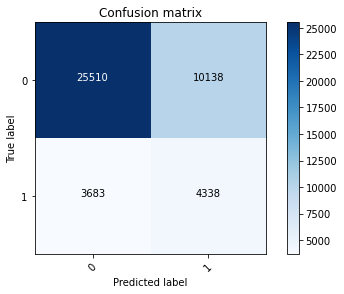

In [130]:
y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes = [0, 1])

In [131]:
perf(y_test, y_pred)

54.0% of the positives are appropriately identified, and 28.000000000000004% of the negatives are appropriately identified.


Test AUC: 0.6827877847356256
train AUC: 0.7622227891411122


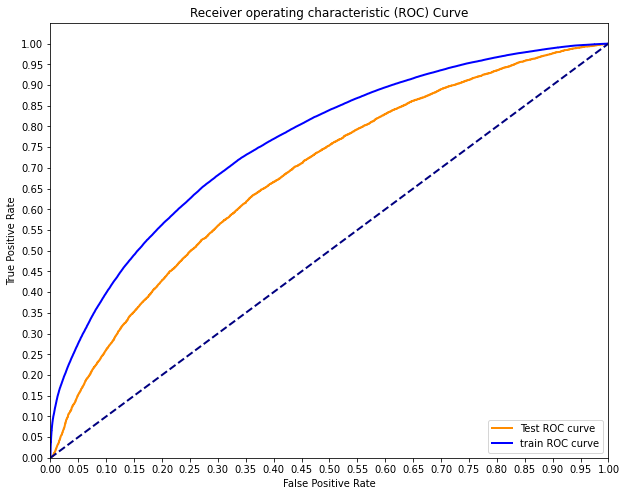

In [132]:
rocurve(model, X_train_resampled, X_test, y_train_resampled, y_test)

**Random Forest**

In [133]:
model = RandomForestClassifier()
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test)

Confusion matrix, without normalization
[[31781  3867]
 [ 5846  2175]]


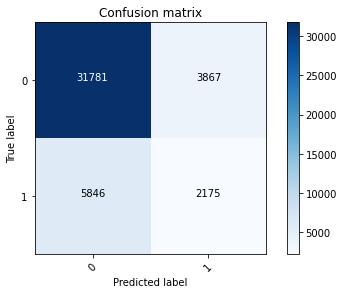

In [134]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=[0,1])

In [135]:
perf(y_test, y_pred)

27.0% of the positives are appropriately identified, and 11.0% of the negatives are appropriately identified.


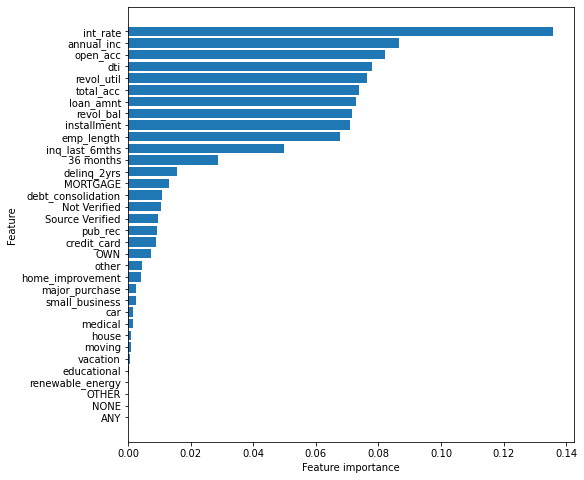

In [136]:
plot_feature_importances(model, X_train)

**Support Vector Machine**

In [137]:
# Finding Amount of Principal Components to Use to Preserve 90% of Variance
min_comps = find_min_pca(X_train_resampled, 0.9)
print(min_comps)

12


In [138]:
pca = PCA(n_components = min_comps)
principalComponents = pca.fit_transform(X_train_resampled)
print(np.sum(pca.explained_variance_ratio_))

0.9078808186359948


In [139]:
model = Pipeline([('pca', PCA(n_components = min_comps)), ('clf', svm.SVC(random_state = 123))])
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test)

Confusion matrix, without normalization
[[22751 12897]
 [ 2787  5234]]


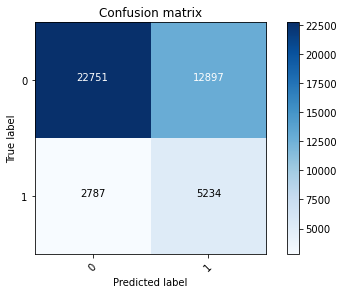

In [140]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes = [0, 1])

In [141]:
perf(y_test, y_pred)

65.0% of the positives are appropriately identified, and 36.0% of the negatives are appropriately identified.


**XGBoost**

In [63]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [64]:
model = xgb.XGBClassifier()
model.fit(X_train_resampled, y_train_resampled)
training_preds = model.predict(X_train_resampled)
X_test2 = np.array(X_test)
y_pred = model.predict(X_test2)
training_accuracy = accuracy_score(y_train_resampled, training_preds)
val_accuracy = accuracy_score(y_test, y_pred)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))
perf(y_test,y_pred)

Training Accuracy: 88.97%
Validation accuracy: 81.17%
10.0% of the positives are appropriately identified, and 3.0% of the negatives are appropriately identified.


In [65]:
param_grid = {
    "learning_rate": [0.1],
    'max_depth': [6,8],
    'min_child_weight': [7,8,10],
    'subsample': [ 0.7,0.9],
    'n_estimators': [5, 30, 100, 250],
}

In [66]:
grid_clf = GridSearchCV(model, param_grid, scoring='recall', cv=None, n_jobs=1)
grid_clf.fit(X_train_resampled, y_train_resampled)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

y_pred = grid_clf.predict(X_test2)

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 8
min_child_weight: 7
n_estimators: 30
subsample: 0.9


Confusion matrix, without normalization
[[30159  5489]
 [ 5115  2906]]


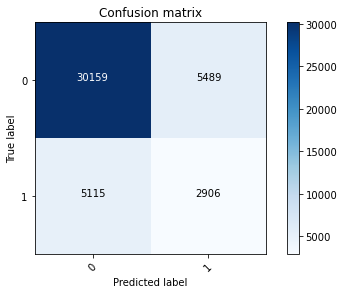

In [67]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=[0,1])

In [68]:
perf(y_test, y_pred)

36.0% of the positives are appropriately identified, and 15.0% of the negatives are appropriately identified.


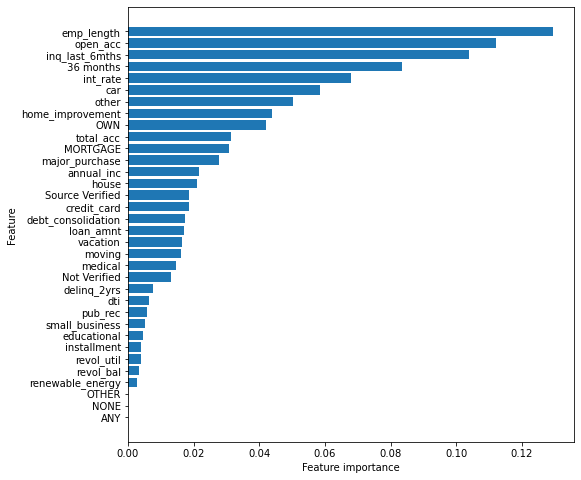

In [69]:
plot_feature_importances(model,X_train)

#### **6. Conclusion**

1. The best result is given by Support Vector Machine model, which gives us 65% of loans that won't be repaid. However, the lender will only fund 36% of the loans that will be paid off.
2. The most important features in determining qualified borrowers are Amount of Open Credit Lines, Interest Rate of Loan, and Employment Length

#### **7. Next Steps**

1. Optimize Random Forest Hyperparameters to Improve Model
2. Work on Class Imbalance to Improve Predicting Power of the Model
3. Determine Levels of Interest Rates Insuring Profitability Despites Undetected Defaults